In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pykalman import KalmanFilter
import joblib

import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
ss = pd.read_csv('../data/SampleSubmission.csv')

## 4.0 EDA + Feature Engineering

climate_vap     -0.221348
climate_aet     -0.211806
climate_pr      -0.170532
precipitation   -0.169218
climate_tmmn    -0.099436
climate_soil    -0.089246
landcover_6     -0.075815
climate_ro      -0.071414
landcover_7     -0.027734
lon             -0.021698
climate_pdsi    -0.014831
landcover_2     -0.008348
landcover_0     -0.008137
landcover_1     -0.007266
landcover_8     -0.005215
landcover_3      0.000964
landcover_4      0.013846
climate_tmmx     0.040500
elevation        0.074576
lat              0.140848
landcover_5      0.151957
climate_srad     0.160517
climate_pet      0.168871
climate_vpd      0.219974
climate_vs       0.261562
climate_def      0.279511
burn_area        1.000000
climate_swe           NaN
Name: burn_area, dtype: float64


<Axes: >

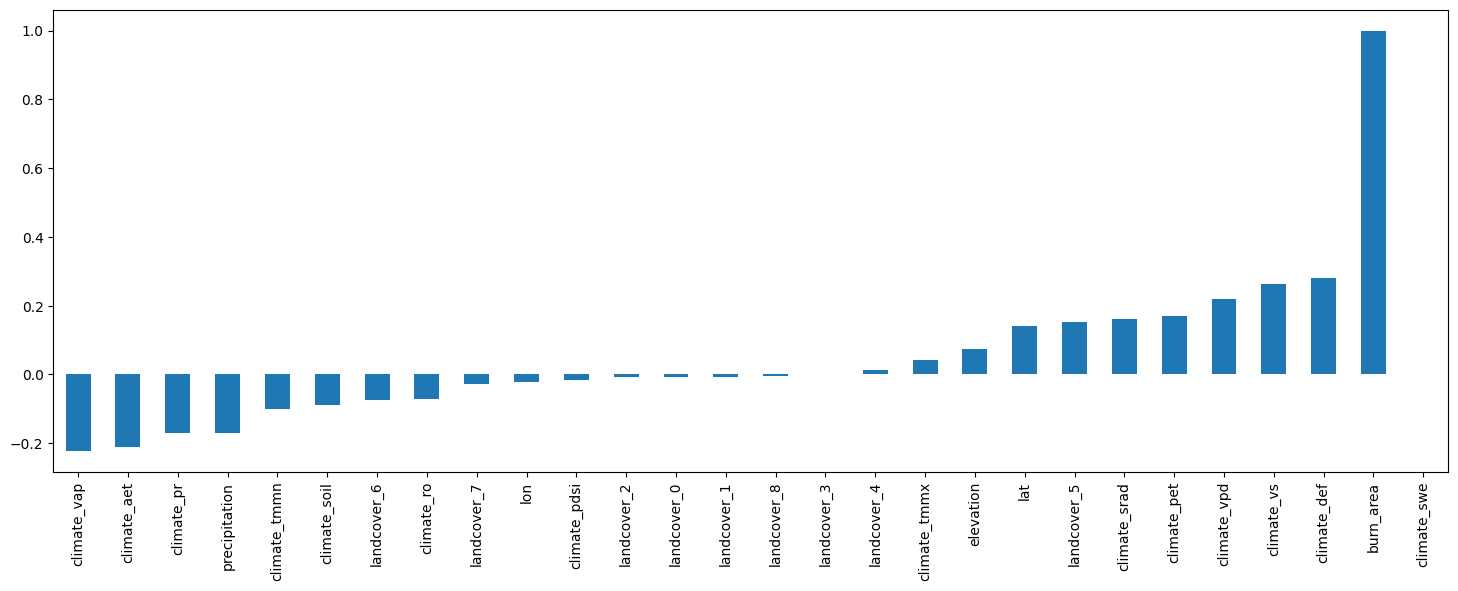

In [12]:
# Look at correlation of all variables with the target (burn_area) variable
# Exclude the inappropriate columns from the original DataFrame
columns_to_exclude = ['ID', 'date', 'month', 'year']
numeric_columns = train.select_dtypes(include=['number']).drop(columns=columns_to_exclude, errors='ignore')

# Calculate the correlation with 'burn_area'
correlation_with_burn_area = numeric_columns.corr()['burn_area']

# Sort the correlation values
sorted_correlation_with_burn_area = correlation_with_burn_area.sort_values()

# Print the sorted correlation values
print(sorted_correlation_with_burn_area)

# Plot the correlations
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

### 4.1 Adding date features

In [16]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [17]:
# Add month and year date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

### 4.2 Adding Real ID column

In [22]:
# Split the ID (eg 127_2017-01-03) to get the area ID
train['real_id'] = pd.to_numeric(train['ID'].apply(lambda x: x.split('_')[0]))
test['real_id'] = pd.to_numeric(test['ID'].apply(lambda x: x.split('_')[0]))

### 4.3 Trend and Seasonality Analysis
We have visually observed the easonality of the burned area.
The country is divided into 533 areas and each area has its own historical data.
We will therefore, convert the data to a time series and split burn_area data into seasonal, underlying trend, and residual components for sample areas.

In [23]:
# Set date column as the index
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

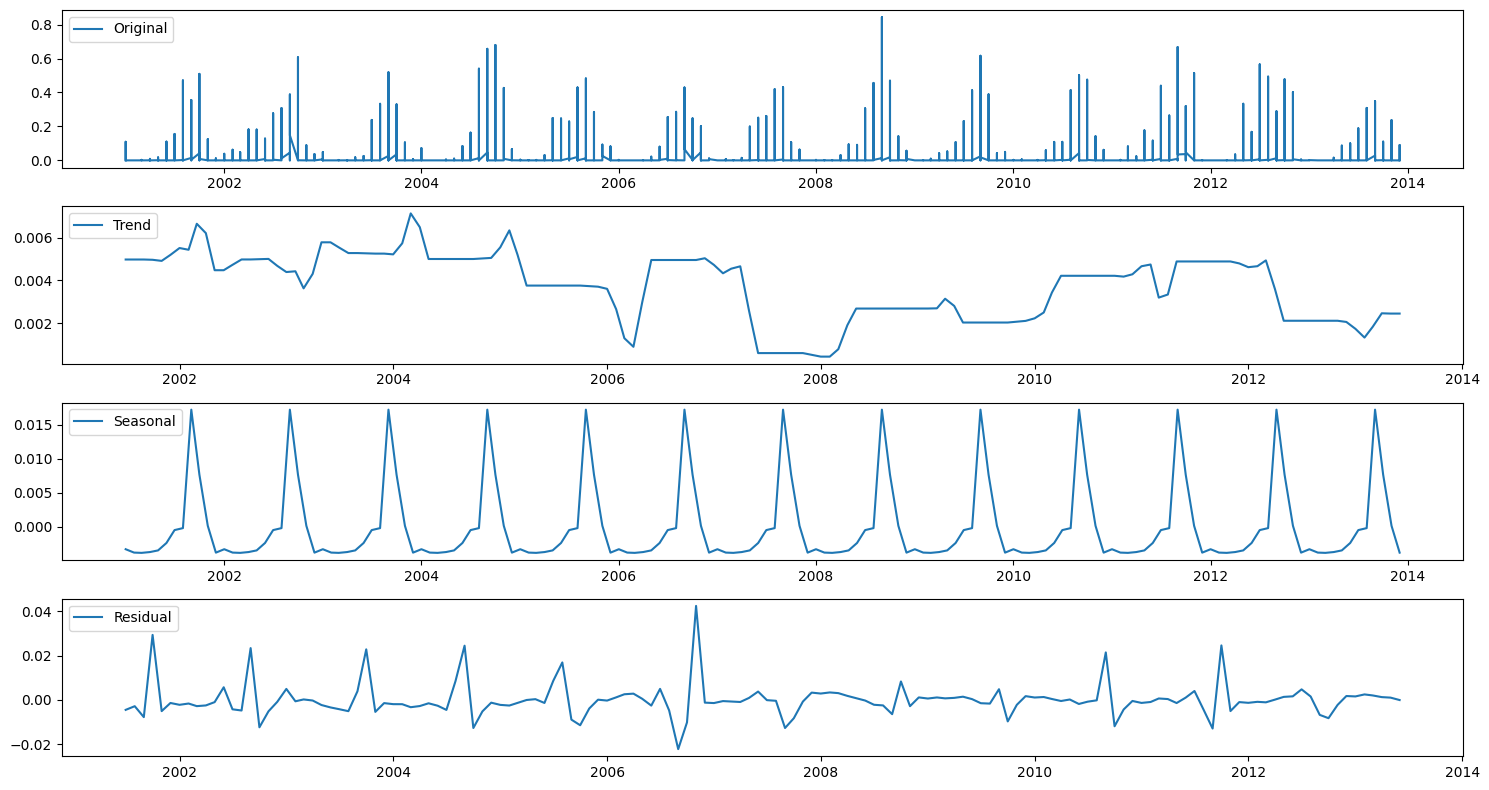

In [24]:
# Time series decomposition of area ID 0
train_0 = train.loc[train.real_id == 0]

decomposition_result = seasonal_decompose(train_0['burn_area'], model='additive', period=12)  # Annual seasonality

# Plot the original time series
plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(train['burn_area'], label='Original')
plt.legend(loc='upper left')

# Plot the trend
plt.subplot(4, 1, 2)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Plot the residual or noise
plt.subplot(4, 1, 4)
plt.plot(decomposition_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

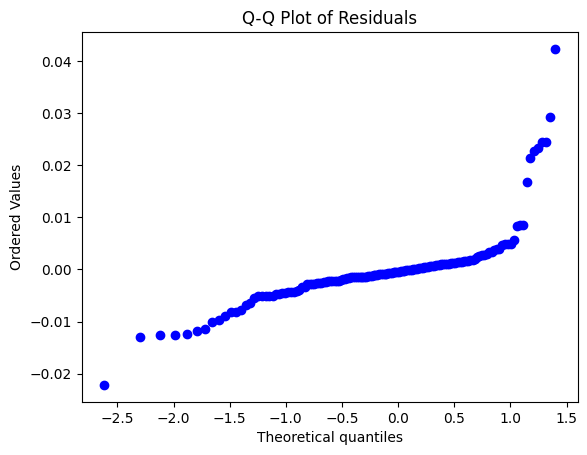

In [25]:
# Plot a Q-Q plot of the residuals to see if they are normally distributed
stats.probplot(decomposition_result.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

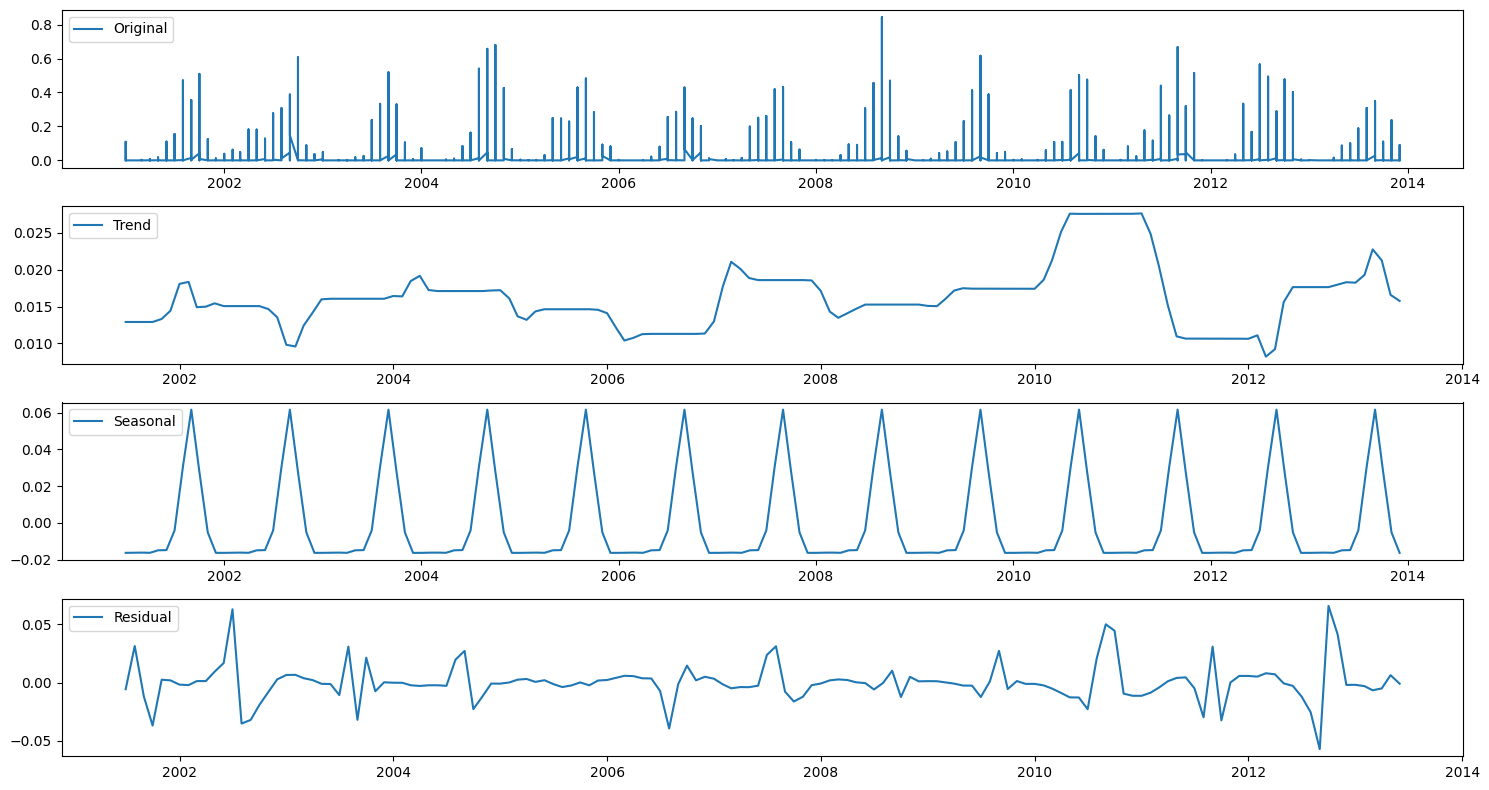

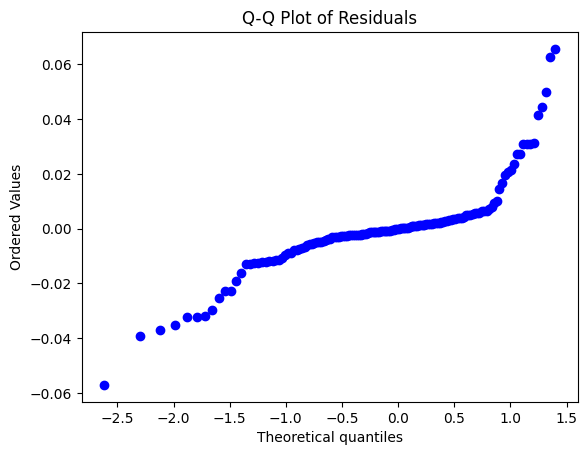

In [26]:
# Time series decomposition of area ID 78
train_78 = train.loc[train.real_id == 78]

decomposition_result = seasonal_decompose(train_78['burn_area'], model='additive', period=12)  # Annual seasonality

# Plot the original time series
plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(train['burn_area'], label='Original')
plt.legend(loc='upper left')

# Plot the trend
plt.subplot(4, 1, 2)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Plot the residual or noise
plt.subplot(4, 1, 4)
plt.plot(decomposition_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot a Q-Q plot of the residuals to see if they are normally distributed
stats.probplot(decomposition_result.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [27]:
# Drop NaN values from residuals
clean_residuals = decomposition_result.resid.dropna()

# Run the ADF test on the cleaned residuals
adf_test = adfuller(clean_residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The residuals are stationary.")
else:
    print("The residuals are not stationary.")

ADF Statistic: -6.011327208858988
p-value: 1.5709161690819873e-07
The residuals are stationary.


In [28]:
# Convert date to string and split at 2011-01-01
X_train = train.loc[train.index.strftime('%Y-%m-%d') < '2011-01-01']
y_test = train.loc[train.index.strftime('%Y-%m-%d') >= '2011-01-01']
print(X_train.shape, y_test.shape)

(63960, 32) (19188, 32)


In [29]:
# Initialize an empty list to store RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Simple model
    baseline_model = auto_arima(X_train_area['burn_area'], seasonal=True)

    # Forecast the same length as the test data
    forecast_length = len(y_test_area)
    predicted_data = baseline_model.predict(n_periods=forecast_length)
    predicted_data = pd.Series(predicted_data, index=y_test_area.index)

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
overall_rmse = np.mean(rmse_values)
print('Overall Test RMSE:', overall_rmse)

Overall Test RMSE: 0.017360797568748237


#### 5.2.2 Tuned Auto ARIMA model

The auto ARIMA model can be tuned to test different combinations of seasonal (P, D, Q) and non-seasonal orders p, d, and q (where p, d, and q represent the autoregressive, differencing, and moving average terms, respectively) and generate the best order combination.

To limit the computation complexity and time, we will set max_order=5, which means that the sum of P, Q, and D or p, q, and d cannot exceed 5.
Augmented Dickey-Fuller test "adf" will be used to determine the optimal differencing term.


NB: From my tests, I realised that some areas such as 270 and 271 have insufficient variability of burned area data, making it impossible for the model to test and determine an appropriate differencing term, d.

In [30]:
# Time Series for area 270
train_270 = train.loc[train.real_id == 270]

# Time Series for area 271
train_271 = train.loc[train.real_id == 271]

# burned area value counts for area 270
train_270['burn_area'].value_counts()

burn_area
0.000000    155
0.024936      1
Name: count, dtype: int64

In [31]:
# burned area value counts for area 271
train_271['burn_area'].value_counts()

burn_area
0.000000    155
0.115663      1
Name: count, dtype: int64

Almost all the area that failed the auto ARIMA model test have only one non-zero value and 155 zeros.

Therefore, in my modelling, I will introduce try and except blocks so that areas whose data cannot be modelled will be imputed with 0 as the prediction.

In [32]:
# Looping through all areas and solving for areas with insufficient data or
# insufficient variability

# Initialize an empty list to store RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Skip if the time series is too short or non-variable
    if len(X_train_area) < 20 or X_train_area['burn_area'].std() == 0:
        print(f"Skipping real_id {real_id} due to insufficient data or no variability. Falling back to zero prediction.")
        # Fall back to simple zero prediction
        predicted_data = np.zeros(len(y_test_area))
    else:
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                     start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                     suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_data = model_arima.predict(n_periods=forecast_length)
            predicted_data = pd.Series(predicted_data, index=y_test_area.index)
        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data = np.zeros(len(y_test_area))

        # Calculate RMSE for the current area ID
        rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data))
        rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Failed to model real_id 102: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to zero prediction.


### 5.3 SARIMAX Models

In [ ]:
# Auto ARIMA model tuning for area 0
# Time Series for area 0
train_0 = train.loc[train.real_id == 0]

model_arima= auto_arima(train_0['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-996.662, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1009.507, Time=6.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1003.832, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-978.049, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-996.507, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-1017.485, Time=2.72 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-1018.488, Time=4.91 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-1018.591, Time=5.64 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-1003.806, Time=1.77 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-1017.922, Time=5.02 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-1012.744, Time=7.64 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-1014.242, Time=3.79 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-1022.930, Time=1.17 sec
 ARIMA(2,0,0)(

In [54]:
# Auto ARIMA model tuning for area 1
# Time Series for area 1
train_1 = train.loc[train.real_id == 1]

model_arima= auto_arima(train_1['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2288.714, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2292.714, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2288.729, Time=0.68 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2288.685, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2293.102, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-2290.714, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-2290.714, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2290.729, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2290.685, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2288.684, Time=0.57 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 3.416 seconds


In [ ]:
# Auto ARIMA model tuning for area 2
# Time Series for area 2
train_2 = train.loc[train.real_id == 2]

model_arima= auto_arima(train_2['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1482.894, Time=3.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1486.894, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1486.598, Time=0.84 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1486.809, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1486.305, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1484.894, Time=0.61 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1484.894, Time=0.84 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-1488.598, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-1486.598, Time=1.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-1484.598, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-1486.864, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1486.832, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1488.809, Time=0.50 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-1486.809, Time=0.51 sec
 ARIM

In [44]:
# Auto ARIMA model tuning for area 78
train_78 = train.loc[train.real_id == 78]

model_arima= auto_arima(train_78['burn_area'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-777.036, Time=2.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-651.771, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-723.275, Time=2.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-704.699, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-613.060, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-686.977, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-721.466, Time=0.22 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-778.496, Time=0.82 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-761.260, Time=1.16 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-774.192, Time=2.44 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-779.166, Time=1.67 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-718.633, Time=1.01 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-782.550, Time=3.40 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-734.265, Time=4.53 sec
 ARIMA(1,0,0)(1,0,1

In [ ]:
# SARIMAX with exogenous variables and train-test split
# Set best order as one set of values obtained via auto ARIMA
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Lagged landcover_5 feature
    train_area['landcover_5_lag1'] = train_area['landcover_5'].shift(1)
    test_area['landcover_5_lag1'] = test_area['landcover_5'].shift(1)

    # Intercation terms
    train_area['climate_def_climate_vs'] = train_area['climate_def'] * train_area['climate_vs']
    test_area['climate_def_climate_vs'] = test_area['climate_def'] * test_area['climate_vs']

    train_area['climate_pet_climate_vpd'] = train_area['climate_pet'] * train_area['climate_vpd']
    test_area['climate_pet_climate_vpd'] = test_area['climate_pet'] * test_area['climate_vpd']

    # Select top correlated features, lagged and interaction features as exogenous variables
    exog_features = ['climate_def', 'climate_vs', 'climate_vpd', 'climate_srad', 'climate_pet',
                     'elevation', 'landcover_5', 'landcover_5_lag1', 'climate_def_climate_vs',
                     'climate_pet_climate_vpd']

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Prepare exogenous variables for the training and test sets
    X_train_exog = X_train_area[exog_features]
    y_test_exog = y_test_area[exog_features]

    # Backward fill NaNs in exog variables
    X_train_exog.fillna(method='bfill', inplace=True)
    y_test_exog.fillna(method='bfill', inplace=True)

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order,
                                exog=X_train_exog)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, exog=y_test_exog, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Interpolate NaN values in the predictions
        predicted_values = predicted_values.interpolate(method='linear')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            predicted_values = pd.Series(predicted_values, index=y_test_area.index)

            # Interpolate NaN values in the predictions
            predicted_values = predicted_values.interpolate(method='linear')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_values = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_values = predicted_values.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_values))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Overall Test RMSE: 0.015369110259848365


In [ ]:
# Univariate SARIMAX with train-test split, Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Set best order as the values obtained via auto ARIMA tuning
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    try:
        # Fit SARIMA model with the best orders on X_train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=y_test_area.index, name='burn_area')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            # Apply Kalman Filter to smooth the predictions
            kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
            predicted_values_kf, _ = kf.filter(predicted_values.values)
            predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data_df = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_data_df = predicted_data_df.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data_df))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Overall Test RMSE: 0.013922985862969662


In [47]:
# Univariate SARIMAX with train-test split and Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Initialize an empty list to RMSE values for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    try:
        # Auto ARIMA model tuning
        model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                  start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                  suppress_warnings=True, stepwise=True, trace=False)
        # Set best order as the values obtained via auto ARIMA
        non_seasonal_order = model_arima.order
        best_seasonal_order = model_arima.seasonal_order

    except Exception as e:
        print(f"Failed to tune real_id {real_id}: {e}. Falling back to default seasonal and non-seasonal order")
        # Default best order terms
        non_seasonal_order = (2, 0, 0)
        best_seasonal_order = (2, 0, 1, 12)

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(X_train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(y_test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=y_test_area.index, name='burn_area')

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating ARIMA forecast")
        try:
            # Auto ARIMA model tuning
            model_arima = auto_arima(X_train_area['burn_area'], m=12, seasonal=True,
                                      start_p=0, start_q=0, max_order=5, test='adf', error_action='ignore',
                                      suppress_warnings=True, stepwise=True, trace=False)
            forecast_length = len(y_test_area)
            predicted_values = model_arima.predict(n_periods=forecast_length)
            # Apply Kalman Filter to smooth the predictions
            kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
            predicted_values_kf, _ = kf.filter(predicted_values.values)
            predicted_data_df = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        except Exception as e:
            print(f"Failed to model real_id {real_id}: {e}. Falling back to zero prediction.")
            # Fall back to simple zero prediction
            predicted_data_df = pd.Series(np.zeros(len(y_test_area)), index=y_test_area.index)

    # Ensure alignment
    predicted_data_df = predicted_data_df.reindex(y_test_area.index, method='nearest')

    # Calculate RMSE for the current area ID
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], predicted_data_df))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Failed to tune real_id 102: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 296: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 368: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.. Falling back to default seasonal and non-seasonal order
Failed to tune real_id 377: Encountered exception in stationarity test ('adf'). This can occur in seasonal settings when a large enough `m` coupled with a large enough `D` difference the training array into too few samples for OLS (input contains 120 samples). Try fitting on a larger training size (raised from LinAlgError: Singular matrix). Fallin

In [39]:
# Univariate SARIMAX trained on full data with Kalman Filter applied to the predictions
# and Auto ARIMA for areas where SARIMAX returns an error

# Set best order as the values obtained via auto ARIMA
non_seasonal_order = (2, 0, 0)
best_seasonal_order = (2, 0, 1, 12)

# Initialize an empty list to store predicted values for each area
predicted_data_list = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    try:
        # Fit SARIMA model with the best orders on train set
        sarimax_model = SARIMAX(train_area['burn_area'],
                                order=non_seasonal_order,
                                seasonal_order=best_seasonal_order)
        sarima_fit = sarimax_model.fit()

        # Forecast for the specific number of months
        forecast_months = len(test_area)

        # Perform the forecast
        sarimax_pred = sarima_fit.get_forecast(steps=forecast_months, freq='MS')

        # Extract predicted values
        predicted_values = sarimax_pred.predicted_mean

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_kf = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        # Add the real_id back to the predicted_data
        predicted_data_df = pd.DataFrame({'ID': str(real_id) + '_' + test_area.index.strftime('%Y-%m-%d').map(str),
                                          'burn_area': predicted_data_kf.values})

    except Exception as e:
        print(f"Failed to model real_id {real_id}: {e}. Generating an ARIMA forecast")
        # Auto ARIMA model with a few adjusted parameters
        model_arima= auto_arima(train_area['burn_area'], m=12, seasonal=True,
                            start_p=0, start_q=0, max_order=5, test='adf', error_action= 'ignore',
                            suppress_warnings=True,
                            stepwise= True, trace= True)

        # Forecast the same length as the test data
        forecast_months = len(test_area)
        predicted_values = model_arima.predict(n_periods=forecast_months)

        # Apply Kalman Filter to smooth the predictions
        kf = KalmanFilter(initial_state_mean=predicted_values.iloc[0], n_dim_obs=1)
        predicted_values_kf, _ = kf.filter(predicted_values.values)
        predicted_data_kf = pd.Series(predicted_values_kf.flatten(), index=test_area.index, name='burn_area')

        # Add the real_id back to the predicted_data
        predicted_data_df = pd.DataFrame({'ID': str(real_id) + '_' + test_area.index.strftime('%Y-%m-%d').map(str),
                                          'burn_area': predicted_data_kf.values})

    # Add predicted data to predicted_data_list
    predicted_data_list.append(predicted_data_df)

Failed to model real_id 35: LU decomposition error.. Generating an ARIMA forecast
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-869.056, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-711.110, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-858.401, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-808.574, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-668.706, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-792.899, Time=1.15 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-860.341, Time=1.35 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-870.439, Time=1.72 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-822.780, Time=3.33 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-871.159, Time=6.67 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-866.720, Time=4.66 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-866.558, Time=2.34 sec
 ARIMA(1,

In [48]:
# Write a pickle file for the predictions
with open('SARIMAX_predicted_data_list.pkl', 'wb') as f:
    joblib.dump(predicted_data_list, f)

## 6.0 Making A Submission

Once we've got some features and a model we're happy with, it's time to submit!

Here we will concatenate the generated list of predictions into one dataframe in such a manner that, predictions for all areas in a certain month will be grouped together chronologically. This will result in a dataframe whose 'ID' column values match the 'ID' column of the test set.

In [51]:
# Initialize an empty dataframe
df_combine = pd.DataFrame(columns=['ID', 'burn_area'])

# Loop through the number of predicted months (48 months)
for n in range(48):
    df = pd.DataFrame(columns=['ID', 'burn_area'])

    # Loop through each area ID
    for i in range(len(predicted_data_list)):
        df = pd.concat([df, predicted_data_list[i].loc[predicted_data_list[n].index == n]], ignore_index=True)
    df_combine = pd.concat([df_combine, df], ignore_index=True)

# View the first 5 rows
df_combine.head(5)

,ID,burn_area
0,0_2014-01-01,5.289462e-04
1,1_2014-01-01,4.535173e-128
2,2_2014-01-01,4.776169e-23
3,3_2014-01-01,-1.306160e-03
4,4_2014-01-01,-3.742735e-04


In [52]:
# Add to submission dataframe and clip the values
ss['burn_area'] = df_combine['burn_area']

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

,ID,burn_area
0,0_2014-01-01,5.289462e-04
1,1_2014-01-01,4.535173e-128
2,2_2014-01-01,4.776169e-23
3,3_2014-01-01,0.000000e+00
4,4_2014-01-01,0.000000e+00


In [ ]:
# Save ready for submission:
ss.to_csv('SARIMAX_fulldata_200_201_Kalman&ARIMA.csv', index=False)